<a href="https://colab.research.google.com/github/anikch/paddy/blob/main/Code2_Paddy_VGG16_exp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [2]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 5.2 MB/s 


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from functools import partial
import posixpath
from keras import models, regularizers, layers, optimizers, losses, metrics
import keras_cv
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!nvidia-smi

Tue Oct 25 20:15:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
colab= '/content/drive/MyDrive'
local= r'G:\My Drive'

code_runtime= colab

In [7]:
tf.__version__

'2.9.2'

In [8]:
file1= 'thesis/dataset/paddy_doctor/train.csv'
inp_file = posixpath.join(code_runtime, file1)

train_table=pd.read_csv(inp_file)
train_table

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [9]:
labels=list(np.unique(train_table['label']))
labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [10]:
train_dir= 'thesis/dataset/paddy_doctor/train/'
val_dir= 'thesis/dataset/paddy_doctor/val/'
img_size= 224

train_files= posixpath.join(code_runtime, train_dir)
test_files= posixpath.join(code_runtime, val_dir)

train_data= tf.keras.utils.image_dataset_from_directory(train_files,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="training",
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(img_size, img_size),
                                                        shuffle=True,
                                                        seed= 42,
                                                        batch_size= 16)

val_data= tf.keras.utils.image_dataset_from_directory(train_files,
                                                        labels= 'inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="validation",
                                                        class_names= labels,
                                                        color_mode='rgb',
                                                        image_size=(img_size, img_size),
                                                        shuffle=True,
                                                        seed= 42,
                                                        batch_size= 16)


test_datagen= ImageDataGenerator()
test_data= test_datagen.flow_from_directory(test_files,
                                            target_size= (img_size, img_size),
                                            batch_size= 16,
                                            shuffle = False, 
                                            class_mode='categorical')

Found 14302 files belonging to 10 classes.
Using 11442 files for training.
Found 14302 files belonging to 10 classes.
Using 2860 files for validation.
Found 1500 images belonging to 10 classes.


In [11]:
class_names = train_data.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [12]:
test_data.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

## Augmentation Pipeline

In [28]:
# data augmentation
def augment_train_data(images, labels):
  inputs= {"images": images, "labels": labels}
  layers= keras_cv.layers.RandAugment.get_standard_policy(value_range=(0, 255), geometric= True, magnitude= 0.5, magnitude_stddev= 0.2)
  layers= layers[1:3] + layers[8:] + [keras_cv.layers.preprocessing.RandomFlip(mode= 'horizontal'),
                         keras_cv.layers.preprocessing.RandomRotation(0.2),
                    keras_cv.layers.preprocessing.RandomRotation(factor= .1, seed= 42),
                    keras_cv.layers.GridMask(ratio_factor= (.0, .3), rotation_factor= (.0,.1), fill_mode= 'gaussian_noise'), 
                    #keras_cv.layers.RandomColorJitter(brightness_factor= .5, contrast_factor= .5, hue_factor= .2, saturation_factor= (.1, .9), value_range= [0, 255])
                    ]
  aug_pipeline= keras_cv.layers.RandomAugmentationPipeline(layers= layers, augmentations_per_image= 3, rate= .5)
  outputs= aug_pipeline(inputs)
  print(*layers)
  return outputs['images'], outputs['labels']

In [29]:
AUTOTUNE= tf.data.AUTOTUNE
train_aug_ds= train_data.map(augment_train_data, num_parallel_calls= tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds= val_data.prefetch(buffer_size= AUTOTUNE)

<keras_cv.layers.preprocessing.equalization.Equalization object at 0x7fdc8b3444d0> <keras_cv.layers.preprocessing.solarization.Solarization object at 0x7fdc8afa9510> <keras.layers.preprocessing.image_preprocessing.RandomTranslation object at 0x7fdc89ebe950> <keras.layers.preprocessing.image_preprocessing.RandomTranslation object at 0x7fdd1eef8690> <keras_cv.layers.preprocessing.random_flip.RandomFlip object at 0x7fdc8b030b90> <keras_cv.layers.preprocessing.random_rotation.RandomRotation object at 0x7fdc8b097f50> <keras_cv.layers.preprocessing.random_rotation.RandomRotation object at 0x7fdc8b0076d0> <keras_cv.layers.preprocessing.grid_mask.GridMask object at 0x7fdc8af42850>


## VGG16 (Augmentation + Transfer Learning + Fine Tune)

In [30]:
base_model= tf.keras.applications.VGG16(
    include_top= False,
    weights= 'imagenet',
    input_shape=(img_size, img_size, 3),
    pooling= 'max'
)

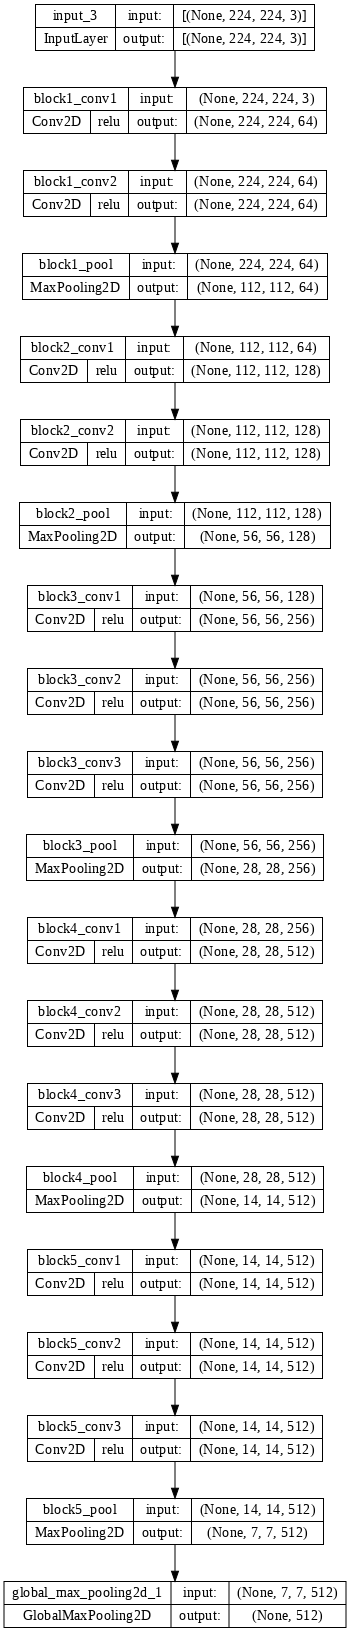

In [31]:
tf.keras.utils.plot_model(
    base_model,
    show_shapes= True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TR",
    expand_nested=False,
    dpi=72,
    layer_range=None,
    show_layer_activations=True,
)

In [32]:
inputs= tf.keras.Input(shape= (img_size, img_size, 3))
preprocess_layer= tf.keras.applications.vgg16.preprocess_input(inputs)
normalization_layer= tf.keras.layers.Rescaling(scale= 1./127.5, offset= -1)(preprocess_layer)
x= base_model(normalization_layer)
x= tf.keras.layers.Dropout(0.25)(x)
x= tf.keras.layers.Dense(256, activation= 'relu')(x)
x= tf.keras.layers.Dropout(0.2)(x)
outputs= tf.keras.layers.Dense(10, activation= 'softmax')(x)

In [33]:
model= tf.keras.Model(inputs= inputs, outputs= outputs, name= "vgg16_TL_augmentation")

In [34]:
model.summary()

Model: "vgg16_TL_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout_2 (Dropout)         (None, 512)     

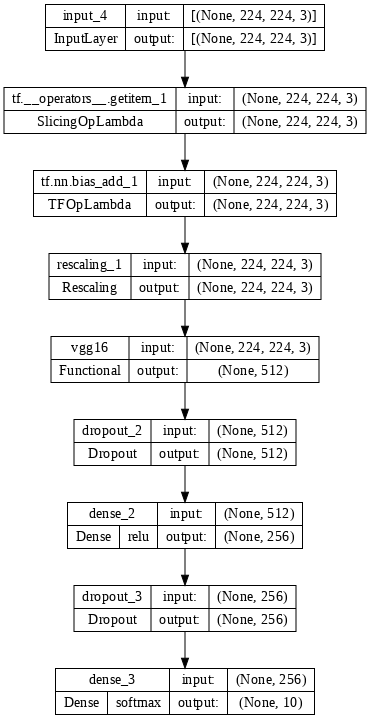

In [35]:
tf.keras.utils.plot_model(
    model,
    show_shapes= True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TR",
    expand_nested=False,
    dpi=72,
    layer_range=None,
    show_layer_activations=True,
)

In [36]:
%%time
n_epochs= 100

filepath= "weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint_callback= ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode= 'max')
early_stop_callback= EarlyStopping(monitor='val_accuracy', patience= 10, verbose= 1, mode='max', restore_best_weights= True)
callbacks_list=[checkpoint_callback, early_stop_callback]

CPU times: user 101 µs, sys: 23 µs, total: 124 µs
Wall time: 129 µs


In [37]:
optimizer_adam_amsgrad= tf.keras.optimizers.Adam(learning_rate= 1e-3, amsgrad= True)
optimizer_adam= tf.keras.optimizers.Adam(learning_rate= 1e-4, amsgrad= False)
optimizer_sgd= tf.keras.optimizers.SGD(learning_rate= 1e-4, momentum= 0.9)

In [38]:
model.compile(
        optimizer = optimizer_sgd,
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy', tfa.metrics.F1Score(average='macro', num_classes= 10)]
        )

In [39]:
history= model.fit(train_aug_ds,
                  epochs= n_epochs,
                  validation_data= val_ds,
                  callbacks= callbacks_list,
                  verbose= 1)

Epoch 1/100
716/716 [==============================] - ETA: 0s - loss: 2.1249 - accuracy: 0.2198 - f1_score: 0.2177
Epoch 1: val_accuracy improved from -inf to 0.42762, saving model to weights-improvement-01-0.4276.hdf5
716/716 [==============================] - 215s 300ms/step - loss: 2.1249 - accuracy: 0.2198 - f1_score: 0.2177 - val_loss: 1.6124 - val_accuracy: 0.4276 - val_f1_score: 0.3891
Epoch 2/100
714/716 [============================>.] - ETA: 0s - loss: 1.5445 - accuracy: 0.4460 - f1_score: 0.4437
Epoch 2: val_accuracy improved from 0.42762 to 0.60000, saving model to weights-improvement-02-0.6000.hdf5
716/716 [==============================] - 31s 43ms/step - loss: 1.5448 - accuracy: 0.4457 - f1_score: 0.4435 - val_loss: 1.1893 - val_accuracy: 0.6000 - val_f1_score: 0.5945
Epoch 3/100
714/716 [============================>.] - ETA: 0s - loss: 1.2154 - accuracy: 0.5752 - f1_score: 0.5707
Epoch 3: val_accuracy improved from 0.60000 to 0.65280, saving model to weights-improveme

In [40]:
model.evaluate(test_data, batch_size= 16, return_dict= True)

94/94 [==============================] - 260s 3s/step - loss: 0.3131 - accuracy: 0.9433 - f1_score: 0.9432


{'loss': 0.31310051679611206,
 'accuracy': 0.9433333277702332,
 'f1_score': 0.9432026147842407}

In [41]:
# Generating Confusion Matrix and Classification Report
Y_pred= model.predict_generator(test_data, 1500// 16 + 1)
y_pred= np.argmax(Y_pred, axis= 1)
print('Confusion Matrix')
conf_matrix= confusion_matrix(test_data.classes, y_pred)
conf_mat = np.array2string(conf_matrix)
#print(conf_matrix)
#print("=============================================================================================")
print('Classification Report')
target_names= test_data.class_indices
class_rep_vgg = classification_report(test_data.classes, y_pred, target_names=target_names)
print(class_rep_vgg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
Classification Report
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.95      0.87      0.91       150
   bacterial_leaf_streak       0.96      0.97      0.96       150
bacterial_panicle_blight       0.98      0.95      0.96       150
                   blast       0.90      0.97      0.94       150
              brown_spot       0.92      0.94      0.93       150
              dead_heart       0.94      0.99      0.96       150
            downy_mildew       0.95      0.92      0.93       150
                   hispa       0.96      0.93      0.95       150
                  normal       0.94      0.96      0.95       150
                  tungro       0.95      0.93      0.94       150

                accuracy                           0.94      1500
               macro avg       0.94      0.94      0.94      1500
            weighted avg       0.94      0.94      0.94      1500



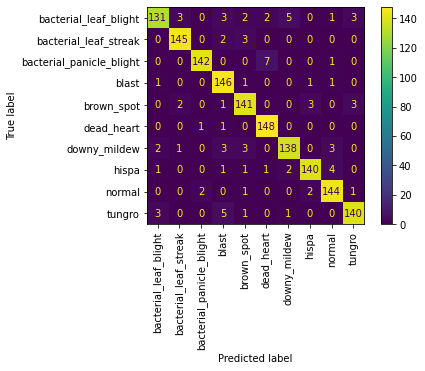

In [42]:
ConfusionMatrixDisplay.from_predictions(test_data.classes, y_pred, display_labels= target_names, xticks_rotation= 'vertical')